# Varible Energy Positron Annihilation Spectroscopy Doppler Broadning Analysis Example
This notebook contains example on how to use pyPAS in order to allow 
The units of length in this package is micrometers

In [74]:
import numpy as np
import xarray as xr
import pandas as pd

from scipy.optimize import minimize, curve_fit, least_squares
from scipy.constants import nano, micro, centi

import matplotlib.pyplot as plt

from pyPAS.positron_implantation_profile import ghosh_material_parameters, makhov_material_parameters, ghosh_profile, makhov_profile, multilayer_implantation_profile
from pyPAS.positron_annihilation_profile import scipy_positrons_annihilation_profile, profile_annihilation_fraction
from pyPAS.positron_annihilation_profile.positron_profile_solver import positrons_annihilation_profile_solver
from pyPAS.sample import Layer, Material, Sample
from pyPAS.vedb import OneBulkDiffusionLengthOptimization

from pyspectrum import germanium_fwhm

from uncertainties import nominal_value, std_dev, ufloat
from uncertainties.unumpy import uarray

data_gos = ghosh_material_parameters()
data_mak = makhov_material_parameters()

#  positron implantaton solver benchmark 1 Layer
Our fast solver seems to solve the equation such the scipy solver (which is slow) and the fast solver solutions aligen 
Also, the solver solve for the surface annihilation fraction with accuracy of more that 99%  (including extrem cases of high and small diffusion and absorbtion length)

In [75]:
Sio2_parameters = data_gos.iloc[19]
Si_parameters = data_gos.iloc[5]

In [76]:
from scipy.constants import nano, micro, centi

L = 40*(nano/micro) # micrometers
L1 = 150*(nano/micro) # micrometers

D = 1
surface_absorbtion_rate = 1e20

lambda_b = D/L**2
lambda_b1 = D/L1**2

m = Material(D,0,lambda_b)
m1 = Material(D,0,lambda_b1)

layer = Layer(0, 0.5, m)
layer1 = Layer(0, 9.5, m1)

si_sample = Sample([layer, layer1], surface_absorbtion_rate)

 find the implementation profile of thermal postrons using gosh profile

In [77]:
implantation_depth = np.linspace(0, si_sample.size, 10000)
positron_implantation_profile = multilayer_implantation_profile(positron_energy=10,
                                                                  depth_vector=implantation_depth,
                                                                  widths=[si_sample.layers[0].width,si_sample.layers[1].width],
                                                                  materials_parameters=[Sio2_parameters, Si_parameters],
                                                                  densities=[Sio2_parameters.density, Si_parameters.density],
                                                                  implantation_profile_function=ghosh_profile)

### Now there are two options, solving the equation with scipy or with our solver. 

scipy solve - problems of calculation time

In [78]:
scipy_positron_profile_sol = scipy_positrons_annihilation_profile(positron_implantation_profile, si_sample, num_of_mesh_cells=2000)
scipy_positron_profile_sol_xarray = xr.DataArray(scipy_positron_profile_sol.y[0], coords={'x': scipy_positron_profile_sol.x})

our solver - problems of calculation time

In [79]:
positron_profile_sol = positrons_annihilation_profile_solver(positron_implantation_profile, si_sample, mesh_size=10000)

### the results of the normlized profile compared with the implantation profile
The solver converged to the same solution

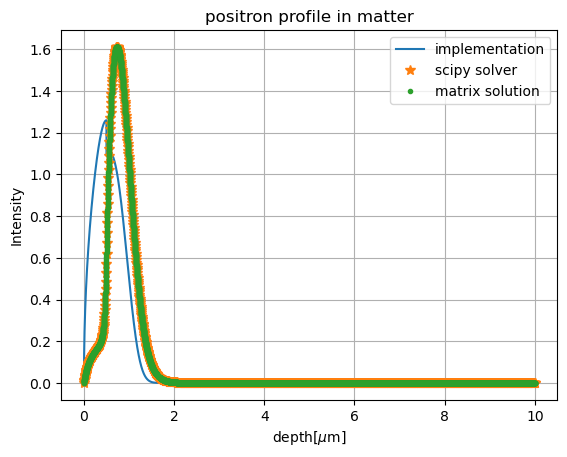

In [80]:
positron_implantation_profile.plot()
(scipy_positron_profile_sol_xarray/scipy_positron_profile_sol_xarray.integrate('x')).plot(marker='*', ls='', markersize=7)
(positron_profile_sol/positron_profile_sol.integrate('x')).plot(marker='.', ls='')

plt.title('positron profile in matter')
plt.grid(True)
plt.xlabel(r'depth[$\mu$m]')
plt.ylabel('Intensity')
plt.legend(['implantation', 'scipy solver', 'matrix solution'])
#plt.xlim([0,0.5])
#plt.ylim([0,0.5])

the annhilation fraction via any channel can be calculated - 

In [82]:
df = profile_annihilation_fraction(positron_profile_sol, si_sample)
df

annihilation_fraction
layer annihilation_type                       
0.0   surface                         0.014957
      bulk                            0.558723
1.0   bulk                            0.426320

Thre is analytical soultion for the annihilation fraction

# diffusion length analysis

## create artificial Cu data for test

Set the artificial sample

In [179]:
Cu_parameters = data_mak.iloc[9].copy()
Cu_parameters.loc['density'] = 8.96

In [246]:
L = 126*(nano/micro) # micrometers
D = 1 * (centi/micro) ** 2 # 100 nanometers


lambda_b = D/L**2

m = Material(D,0,annihilation_rate_bulk=lambda_b)

l = Layer(0., 20, m)

alpha = 1e11
cu_sample = Sample([l], alpha)
implantation_depth = np.linspace(0, cu_sample.size, 100000)

In [240]:
D/alpha

0.01

calculate the S parameter from this sample

In [204]:
# given that
s_artifical_per_channel = {(0, 'surface'): 0.53, (0, 'bulk'): 0.5}
# say we sampled the material with energies np.arange(0,18,0.5)
artificail_energies = np.arange(0.5, 50, 0.5)
# the resulted S parameters for the energies are calculated from the profile
artificail_s = []

for energy in artificail_energies:
    positron_implantation_profile = xr.DataArray(data=makhov_profile(implantation_depth, energy, Cu_parameters.density, Cu_parameters),
                                                   coords={'x':implantation_depth})
    positron_implantation_profile = positron_implantation_profile/positron_implantation_profile.integrate('x')
    positron_profile_sol = positrons_annihilation_profile_solver(positron_implantation_profile, cu_sample, mesh_size=20000)
    df = profile_annihilation_fraction(positron_profile_sol, cu_sample)
    artificail_s_per_energy = 0
    for key in s_artifical_per_channel:
        artificail_s_per_energy = artificail_s_per_energy + (s_artifical_per_channel[key]*df.loc[key]).item()
    artificail_s.append(artificail_s_per_energy)

Text(0, 0.5, 'S Parameter')

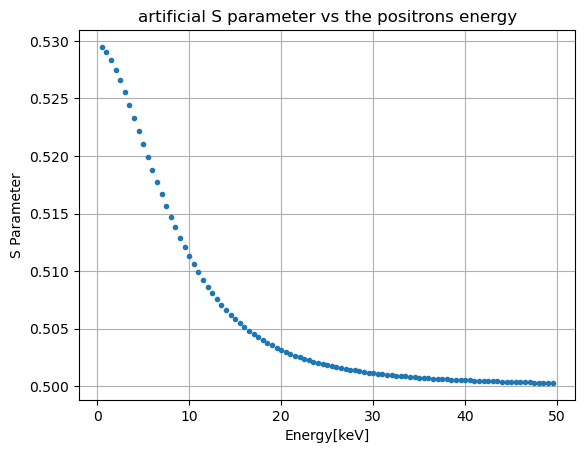

In [205]:
plt.plot(artificail_energies, artificail_s, '.')
plt.title('artificial S parameter vs the positrons energy')
plt.grid(True)
plt.xlabel('Energy[keV]')
plt.ylabel('S Parameter')


## Find the artificial diffusion length using pyPAS tools

preparing the relevant input for fitting

In [206]:
# calculate the implantation profile in the sample
positron_implantation_profiles = []
for energy in artificail_energies:
    positron_implantation_profile = xr.DataArray(data=makhov_profile(implantation_depth, energy, Cu_parameters.density, Cu_parameters),
                                                 coords={'x':implantation_depth})
    positron_implantation_profiles.append(positron_implantation_profile)
    positron_implantation_profiles[-1] = positron_implantation_profiles[-1]/positron_implantation_profiles[-1].integrate('x')
# guess true sample 

In [207]:
# guess true sample 
L  = 100 * (nano/micro)
D = 1 * (centi/micro) ** 2 # normal for metals [cm**2/s]
λ_b = D/L**2 # normal for metals [1/s]

m = Material(diffusion=D, mobility=0, annihilation_rate_bulk=λ_b)

l = Layer(0., 20, m) # infinite sample

alpha = D/(10 * (nano/micro)) # assuming around 10 nm

initial_guess_sample = Sample([l], alpha)

do the fit

In [208]:
vedbfit = OneBulkDiffusionLengthOptimization(positron_implantation_profiles, pd.Series(uarray(artificail_s, np.array(artificail_s)*0.001), artificail_energies), initial_guess_sample)
parm = vedbfit.optimize_diffusion_length(bounds=[(0, 0), (np.inf, np.inf)])
parm

{'layer_0': 0.1256633582451141+/-0.002538397478431794,
 'surface': 0.7082066180610218+/-6158.440257658822}

## indeed the optimization works
The surface isnt detirmine because there is one degree of freedome that we didnt consider

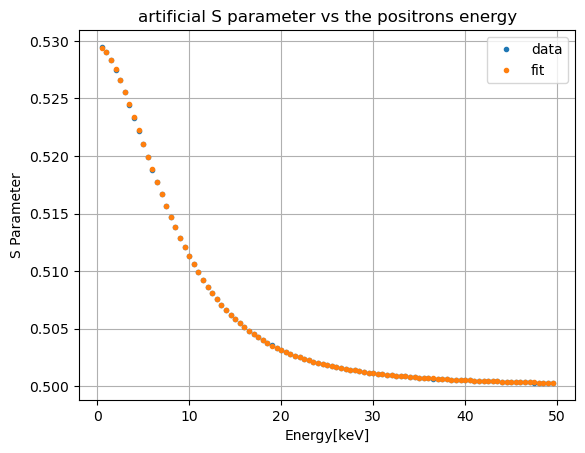

In [209]:
# find s_parm using linear regre
effective_rate_fit = 1/nominal_value(parm['layer_0']) ** 2

effective_surface_rate = 1/nominal_value(parm['surface'])
sample = vedbfit.make_sample(effective_surface_rate , effective_rate_fit)

annihilation_channel_rate_matrix = vedbfit.rate_matrix(sample)
s_vec = np.linalg.lstsq(annihilation_channel_rate_matrix, vedbfit.s_measurement, rcond=None)[0]
s_sample = annihilation_channel_rate_matrix @ s_vec
        
plt.plot(artificail_energies, artificail_s, '.')
plt.plot(artificail_energies, s_sample, '.')
plt.title('artificial S parameter vs the positrons energy')
plt.grid(True)
plt.xlabel('Energy[keV]')
plt.ylabel('S Parameter')
plt.legend(['data', 'fit'])

In [248]:
s_vec

array([0.69783251, 0.50000351])

is the surface annihilation fraction correct?

In [212]:
index = np.argmin(np.abs(artificail_energies-10))
positron_profile_sol = positrons_annihilation_profile_solver(positron_implantation_profiles[index], cu_sample, mesh_size=100000)

In [213]:
df = profile_annihilation_fraction(positron_profile_sol, cu_sample)
df

annihilation_fraction
layer annihilation_type                       
0.0   surface                         0.377087
      bulk                            0.622913

In [214]:
def analytical_annihilation_fraction(profile, diffusion_length, absorbtion_length):
    fraction = xr.DataArray(profile*np.exp(-profile.x/diffusion_length)/(1+absorbtion_length/diffusion_length), coords=profile.coords)
    return fraction.integrate('x').item()

In [215]:
diffusion_length = (cu_sample.layers[0].material.diffusion/sum(cu_sample.layers[0].material.rates.values()))**0.5
absorbtion_length = cu_sample.layers[0].material.diffusion/cu_sample.surface_capture_rate

surface_fraction = analytical_annihilation_fraction(positron_implantation_profiles[index], diffusion_length, absorbtion_length)
100*(surface_fraction - df.loc[(0, 'surface')]['annihilation_fraction'])/surface_fraction

-8.155221613638013e-06

In [216]:
def analytical_annihilation_fraction(profile, diffusion_length, absorbtion_length):
    fraction = xr.DataArray(profile*np.exp(-profile.x/diffusion_length)/(1+absorbtion_length/diffusion_length), coords=profile.coords)
    return fraction.integrate('x').item()

In [235]:
demi_s = []
demi_f = []
for i,e in enumerate(artificail_energies):
    f = analytical_annihilation_fraction(positron_implantation_profiles[i], 126*(nano/micro), 10*(nano/micro))
    demi_f.append(f)
    demi_s.append(f*.4859+(1-f)*0.48)

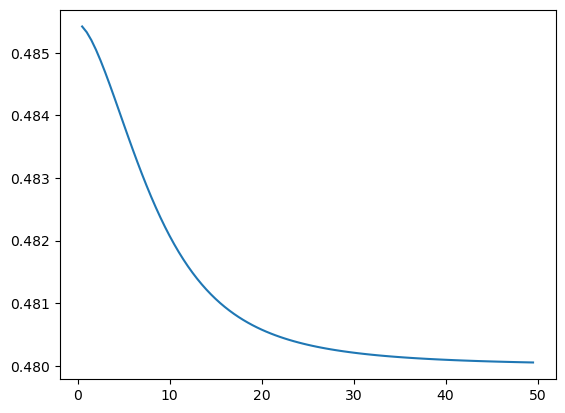

In [236]:
plt.plot(artificail_energies, demi_s)